In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
from torch.utils.data import Dataset

## VAE model

In [3]:
class VAE(nn.Module):

    def __init__(self, embed_size):
        super(VAE, self).__init__()

        Z_dim = X_dim = h_dim = embed_size
        self.Z_dim = Z_dim
        self.X_dim= X_dim
        self.h_dim = h_dim
        self.embed_size= embed_size

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

        # =============================== Q(z|X) ======================================
        self.dense_xh = nn.Linear(X_dim, h_dim)
        init_weights(self.dense_xh)

        self.dense_hz_mu = nn.Linear(h_dim, Z_dim)
        init_weights(self.dense_hz_mu)

        self.dense_hz_var = nn.Linear(h_dim, Z_dim)
        init_weights(self.dense_hz_var)

        # =============================== P(X|z) ======================================
        self.dense_zh = nn.Linear(Z_dim, h_dim)
        init_weights(self.dense_zh)

        self.dense_hx = nn.Linear(h_dim, X_dim)
        init_weights(self.dense_hx)

    def Q(self, X):
        h = nn.ReLU()(self.dense_xh(X))
        z_mu = self.dense_hz_mu(h)
        z_var = self.dense_hz_var(h)
        return z_mu, z_var

    def sample_z(self, mu, log_var):
        mb_size = mu.shape[0]
        eps = Variable(torch.randn(mb_size, self.Z_dim)).cuda()
        return mu + torch.exp(log_var / 2) * eps

    def P(self, z):
        h = nn.ReLU()(self.dense_zh(z))
        X = self.dense_hx(h)
        return X


## AGNN model

In [4]:
class AGNN(torch.nn.Module):
    def __init__(self, user_size, item_size, gender_size, age_size, occupation_size, genre_size, director_size, writer_size, star_size, country_size, embed_size, attention_size, dropout):
        super(AGNN, self).__init__()
        self.user_size = user_size
        self.item_size = item_size
        self.gender_size = gender_size
        self.age_size = age_size
        self.occupation_size = occupation_size
        self.genre_size = genre_size
        self.director_size = director_size
        self.writer_size = writer_size
        self.star_size = star_size
        self.country_size = country_size
        self.embed_size = embed_size
        self.dropout = dropout
        self.attention_size = attention_size

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

        self.user_embed = torch.nn.Embedding(self.user_size, self.embed_size)
        self.item_embed = torch.nn.Embedding(self.item_size, self.embed_size)
        nn.init.xavier_uniform(self.user_embed.weight)
        nn.init.xavier_uniform(self.item_embed.weight)

        self.user_bias = torch.nn.Embedding(self.user_size, 1)
        self.item_bias = torch.nn.Embedding(self.item_size, 1)
        nn.init.constant(self.user_bias.weight, 0)
        nn.init.constant(self.item_bias.weight, 0)

        self.miu = torch.nn.Parameter(torch.zeros(1), requires_grad=True)

        self.gender_embed = torch.nn.Embedding(self.gender_size, self.embed_size)
        self.gender_embed.weight.data.normal_(0, 0.05)
        self.age_embed = torch.nn.Embedding(self.age_size, self.embed_size)
        self.age_embed.weight.data.normal_(0, 0.05)
        self.occupation_embed = torch.nn.Embedding(self.occupation_size, self.embed_size)
        self.occupation_embed.weight.data.normal_(0, 0.05)

        self.genre_embed = torch.nn.Embedding(self.genre_size, self.embed_size)
        self.genre_embed.weight.data.normal_(0, 0.05)
        self.director_embed = torch.nn.Embedding(self.director_size, self.embed_size)
        self.director_embed.weight.data.normal_(0, 0.05)
        self.writer_embed = torch.nn.Embedding(self.writer_size, self.embed_size)
        self.writer_embed.weight.data.normal_(0, 0.05)
        self.star_embed = torch.nn.Embedding(self.star_size, self.embed_size)
        self.star_embed.weight.data.normal_(0, 0.05)
        self.country_embed = torch.nn.Embedding(self.country_size, self.embed_size)
        self.country_embed.weight.data.normal_(0, 0.05)


        #--------------------------------------------------
        self.dense_item_self_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_item_self_siinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_item_onehop_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_item_onehop_siinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_self_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_self_siinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_onehop_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_onehop_siinter = nn.Linear(self.embed_size, self.embed_size)
        init_weights(self.dense_item_self_biinter)
        init_weights(self.dense_item_self_siinter)
        init_weights(self.dense_item_onehop_biinter)
        init_weights(self.dense_item_onehop_siinter)
        init_weights(self.dense_user_self_biinter)
        init_weights(self.dense_user_self_siinter)
        init_weights(self.dense_user_onehop_biinter)
        init_weights(self.dense_user_onehop_siinter)

        self.dense_item_cate_self = nn.Linear(2 * self.embed_size, self.embed_size)
        self.dense_item_cate_hop1 = nn.Linear(2 * self.embed_size, self.embed_size)
        self.dense_user_cate_self = nn.Linear(2 * self.embed_size, self.embed_size)
        self.dense_user_cate_hop1 = nn.Linear(2 * self.embed_size, self.embed_size)
        init_weights(self.dense_item_cate_self)
        init_weights(self.dense_item_cate_hop1)
        init_weights(self.dense_user_cate_self)
        init_weights(self.dense_user_cate_hop1)

        self.dense_item_addgate = nn.Linear(self.embed_size * 2, self.embed_size)
        init_weights(self.dense_item_addgate)
        self.dense_item_erasegate = nn.Linear(self.embed_size * 2, self.embed_size)
        init_weights(self.dense_item_erasegate)
        self.dense_user_addgate = nn.Linear(self.embed_size * 2, self.embed_size)
        init_weights(self.dense_user_addgate)
        self.dense_user_erasegate = nn.Linear(self.embed_size * 2, self.embed_size)

        self.user_vae = VAE(embed_size)
        self.item_vae = VAE(embed_size)

        #----------------------------------------------------
        #concat, mlp融合
        self.FC_pre = nn.Linear(2 * embed_size, 1)
        init_weights(self.FC_pre)

        """# dot
        self.user_bias = nn.Embedding(self.user_size, 1)
        self.item_bias = nn.Embedding(self.item_size, 1)
        self.user_bias.weight.data.normal_(0, 0.01)
        self.item_bias.weight.data.normal_(0, 0.01)
        self.bias = torch.nn.Parameter(torch.rand(1), requires_grad=True)
        self.bias.data.uniform_(0, 0.1)"""

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.2)

    def feat_interaction(self, feature_embedding, fun_bi, fun_si, dimension):
        summed_features_emb_square = (torch.sum(feature_embedding, dim=dimension)).pow(2)
        squared_sum_features_emb = torch.sum(feature_embedding.pow(2), dim=dimension)
        deep_fm = 0.5 * (summed_features_emb_square - squared_sum_features_emb)
        deep_fm = self.leakyrelu(fun_bi(deep_fm))
        bias_fm = self.leakyrelu(fun_si(feature_embedding.sum(dim=dimension)))
        nfm = deep_fm + bias_fm
        return nfm

    def forward(self, user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id, item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country, mode='train'):

        uids_list = user.cuda()
        sids_list = item.cuda()
        if mode == 'train' or mode == 'warm':
            user_embedding = self.user_embed(torch.autograd.Variable(uids_list))
            item_embedding = self.item_embed(torch.autograd.Variable(sids_list))
        if mode == 'ics':
            user_embedding = self.user_embed(torch.autograd.Variable(uids_list))
        if mode == 'ucs':
            item_embedding = self.item_embed(torch.autograd.Variable(sids_list))

        batch_size = item_self_cate.shape[0]
        cate_size = item_self_cate.shape[1]
        director_size = item_self_director.shape[1]
        writer_size = item_self_writer.shape[1]
        star_size = item_self_star.shape[1]
        country_size = item_self_country.shape[1]
        user_onehop_size = user_onehop_id.shape[1]
        item_onehop_size = item_onehop_id.shape[1]

        #------------------------------------------------------GCN-item
        # K=2
        item_onehop_id = self.item_embed(Variable(item_onehop_id))

        item_onehop_cate = self.genre_embed(Variable(item_onehop_cate).view(-1, cate_size)).view(batch_size,item_onehop_size,cate_size, -1)
        item_onehop_director = self.director_embed(Variable(item_onehop_director).view(-1, director_size)).view(batch_size, item_onehop_size, director_size, -1)
        item_onehop_writer = self.writer_embed(Variable(item_onehop_writer).view(-1, writer_size)).view(batch_size, item_onehop_size, writer_size, -1)
        item_onehop_star = self.star_embed(Variable(item_onehop_star).view(-1, star_size)).view(batch_size, item_onehop_size, star_size, -1)
        item_onehop_country = self.country_embed(Variable(item_onehop_country).view(-1, country_size)).view(batch_size, item_onehop_size, country_size, -1)

        item_onehop_feature = torch.cat([item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country], dim=2)
        item_onehop_embed = self.dense_item_cate_hop1(torch.cat([self.feat_interaction(item_onehop_feature, self.dense_item_onehop_biinter,  self.dense_item_onehop_siinter, dimension=2), item_onehop_id], dim=-1))

        # K=1
        item_self_cate = self.genre_embed(Variable(item_self_cate))
        item_self_director = self.director_embed(Variable(item_self_director))
        item_self_writer = self.writer_embed(Variable(item_self_writer))
        item_self_star = self.star_embed(Variable(item_self_star))
        item_self_country = self.country_embed(Variable(item_self_country))

        item_self_feature = torch.cat([item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country], dim=1)
        item_self_feature = self.feat_interaction(item_self_feature, self.dense_item_self_biinter, self.dense_item_self_siinter, dimension=1)

        if mode == 'ics':
            item_mu, item_var = self.item_vae.Q(item_self_feature)
            item_z = self.item_vae.sample_z(item_mu, item_var)
            item_embedding = self.item_vae.P(item_z)
        item_self_embed = self.dense_item_cate_self(torch.cat([item_self_feature, item_embedding], dim=-1))

        item_addgate = self.sigmoid(self.dense_item_addgate(torch.cat([item_self_embed.unsqueeze(1).repeat(1, item_onehop_size, 1), item_onehop_embed], dim=-1)))  # 商品的邻居门，控制邻居信息多少作为输入
        item_erasegate = self.sigmoid(self.dense_item_erasegate(torch.cat([item_self_embed, item_onehop_embed.mean(dim=1)], dim=-1)))
        item_onehop_embed_final = (item_onehop_embed * item_addgate).mean(1)
        item_self_embed = (1 - item_erasegate) * item_self_embed

        item_gcn_embed = self.leakyrelu(item_self_embed + item_onehop_embed_final)  # [batch, embed]

        #----------------------------------------------------------GCN-user
        # K=2
        user_onehop_id = self.user_embed(Variable(user_onehop_id))

        user_onehop_gender_emb = self.gender_embed(Variable(user_onehop_cate[:, :, 0]))
        user_onehop_age_emb = self.age_embed(Variable(user_onehop_cate[:, :, 1]))
        user_onehop_occupation_emb = self.occupation_embed(Variable(user_onehop_cate[:, :, 2]))

        user_onehop_feat = torch.cat([user_onehop_gender_emb.unsqueeze(2), user_onehop_age_emb.unsqueeze(2), user_onehop_occupation_emb.unsqueeze(2)], dim=2)
        user_onehop_embed = self.dense_user_cate_hop1(torch.cat([self.feat_interaction(user_onehop_feat, self.dense_user_onehop_biinter, self.dense_user_onehop_siinter, dimension=2), user_onehop_id], dim=-1))

        # K=1
        user_gender_emb = self.gender_embed(Variable(user_self_cate[:, 0]))
        user_age_emb = self.age_embed(Variable(user_self_cate[:, 1]))
        user_occupation_emb = self.occupation_embed(Variable(user_self_cate[:, 2]))

        user_self_feature = torch.cat([user_gender_emb.unsqueeze(1), user_age_emb.unsqueeze(1), user_occupation_emb.unsqueeze(1)], dim=1)
        user_self_feature = self.feat_interaction(user_self_feature, self.dense_user_self_biinter,  self.dense_user_onehop_siinter, dimension=1)

        if mode == 'ucs':
            user_mu, user_var = self.user_vae.Q(user_self_feature)
            user_z = self.user_vae.sample_z(user_mu, user_var)
            user_embedding = self.user_vae.P(user_z)
        user_self_embed = self.dense_user_cate_self(torch.cat([user_self_feature, user_embedding], dim=-1))

        user_addgate = self.sigmoid(self.dense_user_addgate(torch.cat([user_self_embed.unsqueeze(1).repeat(1, user_onehop_size, 1), user_onehop_embed],dim=-1)))
        user_erasegate = self.sigmoid(self.dense_user_erasegate(torch.cat([user_self_embed, user_onehop_embed.mean(dim=1)], dim=-1)))
        user_onehop_embed_final = (user_onehop_embed * user_addgate).mean(dim=1)
        user_self_embed = (1 - user_erasegate) * user_self_embed

        user_gcn_embed = self.leakyrelu(user_self_embed + user_onehop_embed_final)

        #--------------------------------------------------norm
        item_mu, item_var = self.item_vae.Q(item_self_feature)
        item_z = self.item_vae.sample_z(item_mu, item_var)
        item_preference_sample = self.item_vae.P(item_z)

        user_mu, user_var = self.user_vae.Q(user_self_feature)
        user_z = self.user_vae.sample_z(user_mu, user_var)
        user_preference_sample = self.user_vae.P(user_z)

        recon_loss = torch.norm(item_preference_sample - item_embedding) + torch.norm(user_preference_sample - user_embedding)
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(item_z) + item_mu ** 2 - 1. - item_var, 1)) + \
                  torch.mean(0.5 * torch.sum(torch.exp(user_z) + user_mu ** 2 - 1. - user_var, 1))

        ####################################prediction#####################################################

        #concat -> mlp
        bu = self.user_bias(Variable(uids_list))
        bi = self.item_bias(Variable(sids_list))
        #pred = (user_gcn_embed * item_gcn_embed).sum(1, keepdim=True) + bu + bi + (self.miu).repeat(batch_size, 1)
        tmp = torch.cat([user_gcn_embed, item_gcn_embed], dim=1)
        pred = self.FC_pre(tmp) + (user_gcn_embed * item_gcn_embed).sum(1, keepdim=True) + bu + bi + (self.miu).repeat(batch_size, 1)

        return pred.squeeze(), recon_loss, kl_loss


In [5]:
%pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.9 MB/s eta 0:00:00


In [6]:
import os, time, argparse
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
from collections import OrderedDict
import json
from torch.autograd import Variable

In [7]:
def get_data_list(ftrain, batch_size):
    f = open(ftrain, 'r')
    train_list = []
    for eachline in f:
        eachline = eachline.strip().split('\t')
        u, i, l = int(eachline[0]), int(eachline[1]), float(eachline[2])
        train_list.append([u, i, l])
    num_batches_per_epoch = int((len(train_list) - 1) / batch_size) + 1
    return num_batches_per_epoch, train_list

def get_batch_instances(train_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict, batch_size, user_nei_dict, item_nei_dict, shuffle=True):
    num_batches_per_epoch = int((len(train_list) - 1) / batch_size) + 1
    def data_generator(train_list):
        data_size = len(train_list)
        user_feature_arr = np.array(list(user_feature_dict.values()))
        max_user_cate_size = user_feature_arr.shape[1]

        item_genre_arr = np.array(list(item_feature_dict.values())) #len=6 ,0
        item_director_arr = np.array(list(item_director_dict.values())) #len=3 ,6
        item_writer_arr = np.array(list(item_writer_dict.values())) #len=3, 9
        item_star_arr = np.array(list(item_star_dict.values())) #len=3, 12
        item_country_arr = np.array(list(item_country_dict.values()))   #len=8, 15

        item_feature_arr = np.concatenate([item_genre_arr, item_director_arr, item_writer_arr, item_star_arr, item_country_arr], axis=1)
        max_item_cate_size = item_feature_arr.shape[1]

        item_layer1_nei_num = FLAGS.item_layer1_nei_num
        user_layer1_nei_num = FLAGS.user_layer1_nei_num

        if shuffle == True:
            np.random.shuffle(train_list)
        train_list = np.array(train_list)

        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            current_batch_size = end_index - start_index

            u = train_list[start_index: end_index][:, 0].astype(np.int64)
            i = train_list[start_index: end_index][:, 1].astype(np.int64)
            l = train_list[start_index: end_index][:, 2]

            i_self_cate = np.zeros([current_batch_size, max_item_cate_size], dtype=np.int64)
            i_onehop_id = np.zeros([current_batch_size, item_layer1_nei_num], dtype=np.int64)
            i_onehop_cate = np.zeros([current_batch_size, item_layer1_nei_num, max_item_cate_size], dtype=np.int64)

            u_self_cate = np.zeros([current_batch_size, max_user_cate_size], dtype=np.int64)
            u_onehop_id = np.zeros([current_batch_size, user_layer1_nei_num], dtype=np.int64)
            u_onehop_cate = np.zeros([current_batch_size, user_layer1_nei_num, max_user_cate_size], dtype=np.int64)

            for index, each_i in enumerate(i):
                i_self_cate[index] = item_feature_arr[each_i]    #item_self_cate

                tmp_one_nei = item_nei_dict[each_i][0]
                tmp_prob = item_nei_dict[each_i][1]
                if len(tmp_one_nei) > item_layer1_nei_num:  #re-sampling
                    tmp_one_nei = np.random.choice(tmp_one_nei, item_layer1_nei_num, replace=False, p=tmp_prob)
                elif len(tmp_one_nei) < item_layer1_nei_num:
                    tmp_one_nei = np.random.choice(tmp_one_nei, item_layer1_nei_num, replace=True, p=tmp_prob)
                tmp_one_nei[-1] = each_i

                i_onehop_id[index] = tmp_one_nei    #item_1_neigh
                i_onehop_cate[index] = item_feature_arr[tmp_one_nei]  #item_1_neigh_cate

            for index, each_u in enumerate(u):
                u_self_cate[index] = user_feature_dict[each_u]  # item_self_cate

                tmp_one_nei = user_nei_dict[each_u][0]
                tmp_prob = user_nei_dict[each_u][1]
                if len(tmp_one_nei) > user_layer1_nei_num:  # re-sampling
                    tmp_one_nei = np.random.choice(tmp_one_nei, user_layer1_nei_num, replace=False, p=tmp_prob)
                elif len(tmp_one_nei) < user_layer1_nei_num:
                    tmp_one_nei = np.random.choice(tmp_one_nei, user_layer1_nei_num, replace=True, p=tmp_prob)
                tmp_one_nei[-1] = each_u

                u_onehop_id[index] = tmp_one_nei  # user_1_neigh
                u_onehop_cate[index] = user_feature_arr[tmp_one_nei]  # user_1_neigh_cate

            yield ([u, i, l, u_self_cate, u_onehop_id, u_onehop_cate, i_self_cate, i_onehop_id, i_onehop_cate])
    return data_generator(train_list)


In [8]:
def metrics(model, test_dataloader):
    label_lst, pred_lst = [], []
    rmse, mse, mae = 0,0,0
    count = 0
    for batch_data in test_dataloader:
        user = torch.LongTensor(batch_data[0]).cuda()
        item = torch.LongTensor(batch_data[1]).cuda()
        label = torch.FloatTensor(batch_data[2]).cuda()
        user_self_cate = torch.LongTensor(batch_data[3]).cuda()
        user_onehop_id = torch.LongTensor(batch_data[4]).cuda()
        user_onehop_cate = torch.LongTensor(batch_data[5]).cuda()
        item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country = torch.LongTensor(
            batch_data[6])[:, 0:6].cuda(), torch.LongTensor(batch_data[6])[:, 6:9].cuda(), torch.LongTensor(
            batch_data[6])[:, 9:12].cuda(), torch.LongTensor(batch_data[6])[:, 12:15].cuda(), torch.LongTensor(
            batch_data[6])[:, 15:].cuda()
        item_onehop_id = torch.LongTensor(batch_data[7]).cuda()
        item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country = torch.LongTensor(
            batch_data[8])[:, :, 0:6].cuda(), torch.LongTensor(batch_data[8])[:, :, 6:9].cuda(), torch.LongTensor(
            batch_data[8])[:, :, 9:12].cuda(), torch.LongTensor(batch_data[8])[:, :, 12:15].cuda(), torch.LongTensor(
            batch_data[8])[:, :, 15:].cuda()

        prediction, recon_loss, kl_loss = model(user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate,
                           item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id,
                           item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star,
                           item_onehop_country, mode = mode)
        prediction = prediction.cpu().data.numpy()
        prediction = prediction.reshape(prediction.shape[0])
        label = label.cpu().numpy()
        my_rmse = np.sum((prediction - label) ** 2)
        my_mse = np.sum((prediction - label) ** 2)
        my_mae = np.sum(np.abs(prediction - label))
        # my_rmse = torch.sqrt(torch.sum((prediction - label) ** 2) / FLAGS.batch_size)
        rmse+=my_rmse
        mse+=my_mse
        mae+=my_mae
        count += len(user)
        label_lst.extend(list([float(l) for l in label]))
        pred_lst.extend(list([float(l) for l in prediction]))

    my_mse = mse/count
    my_rmse = np.sqrt(rmse/count)
    my_mae = mae/count
    return my_rmse, my_mse, my_mae, label_lst, pred_lst

In [9]:
class Flags:
  def __init__(self, lr, dropout, batch_size, gpu, epochs, clip_norm, embed_size, attention_size, item_layer1_nei_num, user_layer1_nei_num, vae_lambda):
    self.batch_size = batch_size
    self.lr = lr
    self.dropout = dropout
    self.gpu = gpu
    self.epochs = epochs
    self.clip_norm = clip_norm
    self.embed_size = embed_size
    self.attention_size = attention_size
    self.item_layer1_nei_num = item_layer1_nei_num
    self.user_layer1_nei_num = user_layer1_nei_num
    self.vae_lambda = vae_lambda

In [10]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [11]:
FLAGS = Flags(lr=0.0005, dropout=0.5, batch_size=128, gpu=0,
              epochs=20, clip_norm=5.0, embed_size=40,
              attention_size=50, # not specified in paper so leave as argparse default
              item_layer1_nei_num=10, # use argparse default

              user_layer1_nei_num=10, # use argparse default
              vae_lambda=1)

In [29]:
def create_training_data(output_dat_filename, augmented_data_df,
                         num_users=100, num_movies=300):
  ucs_train_df = pd.read_csv("ucs_train.dat", sep="\t",
                           header=None, names=["userId", "movieId", "rating"],
                             index_col="userId").reset_index()
  # augment ucs (user cold start) training data
  # total number of users 944
  total_user_count = 944
  # total number of movies 1683
  total_movie_count = 1683
  random_users = np.random.randint(low=1, high=total_user_count, size=num_users)
  random_movies = np.random.randint(low=1, high=total_movie_count, size=num_movies)
  train_with_gan_df = pd.DataFrame(ucs_train_df)
  iter_cnt = 0
  for user_id in random_users:
    train_user_id_df = ucs_train_df[ucs_train_df["userId"] == user_id]
    augmented_user_id_df = augmented_data_df[augmented_data_df["userId"] == user_id]
    print(f"at iteration {iter_cnt}")
    iter_cnt += 1
    # iterate through train_user_movies to see which ones have already rated
    # if not rated then use GAN rating
    for movie_id in random_movies:
      # if user has not rated movie
      if not train_user_id_df[train_user_id_df["movieId"] == movie_id].any().all():
        rating = augmented_user_id_df[augmented_user_id_df['movieId'] == movie_id]["rating"]
        if rating.empty:
          continue
        new_df = pd.DataFrame({"userId": user_id, "movieId": movie_id, "rating": rating})
        train_with_gan_df = pd.concat([train_with_gan_df, new_df])
  train_with_gan_df.to_csv(output_dat_filename, sep="\t", header=False, index=False)
  return train_with_gan_df

In [14]:
%cd drive/MyDrive/CS247/Project/AttributeGNN/ml100k

/content/drive/MyDrive/CS247/Project/AttributeGNN/ml100k


## create training data

In [30]:
llm_rating_df = pd.read_csv("llm_user_item_predictions.txt", sep=", ",
                                header=None, names=["userId", "movieId", "rating"],
                                index_col="userId").reset_index()
llm_rating_df = llm_rating_df[llm_rating_df["rating"] > 2]
f_train_with_augmented = "ucs_train_llm_rating_greater_than_2.dat"
train_with_gan_df = create_training_data(f_train_with_augmented, llm_rating_df)

<ipython-input-30-f6c236fa75d5>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  llm_rating_df = pd.read_csv("llm_user_item_predictions.txt", sep=", ",


at iteration 0
at iteration 1
at iteration 2
at iteration 3
at iteration 4
at iteration 5
at iteration 6
at iteration 7
at iteration 8
at iteration 9
at iteration 10
at iteration 11
at iteration 12
at iteration 13
at iteration 14
at iteration 15
at iteration 16
at iteration 17
at iteration 18
at iteration 19
at iteration 20
at iteration 21
at iteration 22
at iteration 23
at iteration 24
at iteration 25
at iteration 26
at iteration 27
at iteration 28
at iteration 29
at iteration 30
at iteration 31
at iteration 32
at iteration 33
at iteration 34
at iteration 35
at iteration 36
at iteration 37
at iteration 38
at iteration 39
at iteration 40
at iteration 41
at iteration 42
at iteration 43
at iteration 44
at iteration 45
at iteration 46
at iteration 47
at iteration 48
at iteration 49
at iteration 50
at iteration 51
at iteration 52
at iteration 53
at iteration 54
at iteration 55
at iteration 56
at iteration 57
at iteration 58
at iteration 59
at iteration 60
at iteration 61
at iteration 62
at

In [31]:
ucs_train_df = pd.read_csv("ucs_train.dat", sep="\t",
                           header=None, names=["userId", "movieId", "rating"],
                             index_col="userId").reset_index()
# length of original data
len(ucs_train_df)

79417

In [32]:
len(train_with_gan_df)

79491

## user cold start train loop

In [33]:
rmse_user_cold, mse_user_cold, mae_user_cold = [], [], []

In [41]:
def user_cold_start_train_loop():
    #item cold start
    """
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_ics_uuii_0.20.pkl'
    f_train = '../ml100k/ics_train.dat'
    f_test = '../ml100k/ics_val.dat'
    f_model = '../ml100k/agnn_ics_'
    """

    # user cold start
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_ucs_uuii.pkl'
    f_train = f_train_with_augmented
    f_test = '../ml100k/ucs_val.dat'
    f_model = '../ml100k/agnn_ucs_'

    """# warm start
    f_info = '../ml100k/uiinfo.pkl'
    f_neighbor = '../ml100k/neighbor_aspect_extension_2_zscore_warm_uuii.pkl'
    f_train = '../ml100k/warm_train.dat'
    f_test = '../ml100k/warm_val.dat'
    f_model = '../ml100k/agnn_warm_'
    mode = 'warm'"""

    # use best hyperparameters from paper
    # see section 4.1.4 and 4.3 for description of how they got them

    print("\nParameters:")
    print(FLAGS)

    with open(f_neighbor, 'rb') as f:
        neighbor_dict = pickle.load(f)
    user_nei_dict = neighbor_dict['user_nei_dict']
    item_nei_dict = neighbor_dict['item_nei_dict']
    director_num = neighbor_dict['director_num']
    writer_num = neighbor_dict['writer_num']
    star_num = neighbor_dict['star_num']
    country_num = neighbor_dict['country_num']

    item_director_dict = neighbor_dict['item_director_dict']    #dict[i]=[x,x,x]
    item_writer_dict = neighbor_dict['item_writer_dict']        #dict[i]=[x,x,x]
    item_star_dict = neighbor_dict['item_star_dict']            #dict[i]=[x,x,x]
    item_country_dict = neighbor_dict['item_country_dict']      #dict[i]=[x,x,x,x,x,x,x,x]

    with open(f_info, 'rb') as f:
        item_info = pickle.load(f)
    user_num = item_info['user_num']
    item_num = item_info['item_num']
    gender_num = item_info['gender_num']
    age_num = item_info['age_num']
    occupation_num = item_info['occupation_num']
    genre_num = item_info['genre_num']
    user_feature_dict = item_info['user_feature_dict']  #gender, age, occupation    dict[u]=[x,x,x]
    item_feature_dict = item_info['item_feature_dict']  #genre                      dict[i]=[x,x,x,x,x,x]

    print("user_num {}, item_num {}, gender_num {}, age_num {}, occupation_num {}, genre_num {}, director_num {}, writer_num {}, star_num {}, country_num {}, mode {} ".format(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, mode))


    train_steps, train_list = get_data_list(f_train, batch_size=FLAGS.batch_size)
    test_steps, test_list = get_data_list(f_test, batch_size=FLAGS.batch_size)

    model = AGNN(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, FLAGS.embed_size, FLAGS.attention_size, FLAGS.dropout)
    model.cuda()

    loss_function = torch.nn.MSELoss(size_average=False)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=FLAGS.lr, weight_decay=0.001)

    writer = SummaryWriter()  # For visualization
    #f_loss_curve = open('tmp_loss_curve.txt', 'w')
    best_rmse = 5

    count = 0
    for epoch in range(FLAGS.epochs):
        #tmp_main_loss, tmp_vae_loss = [], []
        model.train()  # Enable dropout (if have).
        start_time = time.time()
        train_dataloader = get_batch_instances(train_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict,  batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=True)
        for idx, batch_data in enumerate(train_dataloader): #u, i, l, u_self_cate, u_onehop_id, u_onehop_rating, u_onehop_cate, i_self_cate, i_onehop_id, i_onehop_cate
            user = torch.LongTensor(batch_data[0]).cuda()
            item = torch.LongTensor(batch_data[1]).cuda()
            label = torch.FloatTensor(batch_data[2]).cuda()
            user_self_cate = torch.LongTensor(batch_data[3]).cuda()
            user_onehop_id = torch.LongTensor(batch_data[4]).cuda()
            user_onehop_cate = torch.LongTensor(batch_data[5]).cuda()
            item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country = torch.LongTensor(batch_data[6])[:, 0:6].cuda(), torch.LongTensor(batch_data[6])[:, 6:9].cuda(), torch.LongTensor(batch_data[6])[:, 9:12].cuda(), torch.LongTensor(batch_data[6])[:, 12:15].cuda(), torch.LongTensor(batch_data[6])[:, 15:].cuda()
            item_onehop_id = torch.LongTensor(batch_data[7]).cuda()
            item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country = torch.LongTensor(batch_data[8])[:, :, 0:6].cuda(), torch.LongTensor(batch_data[8])[:, :, 6:9].cuda(), torch.LongTensor(batch_data[8])[:, :, 9:12].cuda(), torch.LongTensor(batch_data[8])[:, :, 12:15].cuda(), torch.LongTensor(batch_data[8])[:, :, 15:].cuda()

            model.zero_grad()
            prediction, recon_loss, kl_loss = model(user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id, item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country, mode='train')

            label = Variable(label)

            main_loss = loss_function(prediction, label)
            loss = main_loss + FLAGS.vae_lambda * (recon_loss + kl_loss)

            loss.backward()
            # nn.utils.clip_grad_norm(model.parameters(), FLAGS.clip_norm)
            optimizer.step()
            writer.add_scalar('data/loss', loss.data, count)
            count += 1

        tmploss = torch.sqrt(loss / FLAGS.batch_size)
        print(50 * '#')
        print('epoch: ', epoch, '     ', tmploss.detach())

        model.eval()
        print('time = ', time.time() - start_time)
        test_dataloader = get_batch_instances(test_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict, batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=False)
        rmse, mse, mae, label_lst, pred_lst = metrics(model, test_dataloader)
        rmse_user_cold.append(rmse)
        mse_user_cold.append(mse)
        mae_user_cold.append(mae)
        print('test rmse,mse,mae: ', rmse,mse,mae)

## user cold start evaluation

In [42]:
mode = 'ucs'
user_cold_start_train_loop()


Parameters:
user_num 944, item_num 1683, gender_num 2, age_num 7, occupation_num 21, genre_num 19, director_num 1112, writer_num 2016, star_num 2568, country_num 128, mode ucs 


<ipython-input-4-d63240c34650>:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.user_embed.weight)
<ipython-input-4-d63240c34650>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.item_embed.weight)
<ipython-input-4-d63240c34650>:31: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.user_bias.weight, 0)
<ipython-input-4-d63240c34650>:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.item_bias.weight, 0)
<ipython-input-4-d63240c34650>:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
<ipython-input-4-d63240c34650>:22: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
<ipython-input-3-58aca48512

##################################################
epoch:  0       tensor(0.2728, device='cuda:0')
time =  28.45921802520752
test rmse,mse,mae:  1.0393449453692387 1.0802379154645858 0.8418298189502088
##################################################
epoch:  1       tensor(0.1901, device='cuda:0')
time =  27.850297212600708
test rmse,mse,mae:  1.0337937108481825 1.0687294365892557 0.8406415008128295
##################################################
epoch:  2       tensor(0.2559, device='cuda:0')
time =  28.302163124084473
test rmse,mse,mae:  1.025364910065783 1.0513731987942112 0.8218825028495528
##################################################
epoch:  3       tensor(0.0937, device='cuda:0')
time =  27.65086841583252
test rmse,mse,mae:  1.0483807117750041 1.0991021168218644 0.8591642255124687
##################################################
epoch:  4       tensor(0.3723, device='cuda:0')
time =  29.38109850883484
test rmse,mse,mae:  1.0218922328074482 1.0442637354721918 0.819635

KeyboardInterrupt: 

In [39]:
np.argmin(rmse_user_cold), rmse_user_cold[np.argmin(rmse_user_cold)]

(8, 1.0186191713334658)

In [40]:
mae_user_cold[np.argmin(rmse_user_cold)]

0.8140957707283373

In [37]:
print(f"rmse = {rmse_user_cold}")
print(f"mse = {mse_user_cold}")
print(f"mae = {mae_user_cold}")

rmse = [1.0564767701567477, 1.0376584597573741, 1.0238106986772593, 1.0238630020649102, 1.0208028014100365, 1.0284672387358682, 1.0406661718156267, 1.0402793564473651, 1.0186191713334658, 1.065499878387347, 1.0383364266250854, 1.046228199066416, 1.0299713632165428, 1.0583620652781323, 1.0471177944523782, 1.0565584345241117, 1.0443982013734967, 1.0501986868524096, 1.0578089441099003, 1.0347151131545216]
mse = [1.1161431658808334, 1.0767350791060462, 1.0481883467260176, 1.0482954469973704, 1.0420383593665785, 1.0577448611529814, 1.0829860811613916, 1.082181139450544, 1.0375850162080766, 1.1352899908434515, 1.0781425348565512, 1.0945934445217562, 1.0608410090461438, 1.1201302612197936, 1.096455675458813, 1.1163157255640417, 1.090767603032195, 1.1029172818665254, 1.1189597622389025, 1.0706353653903744]
mae = [0.8699210842977498, 0.8477082416753301, 0.8282209406648254, 0.8277001117053373, 0.8180893137822988, 0.8360573074036134, 0.8520128918894119, 0.849906513284723, 0.8140957707283373, 0.87

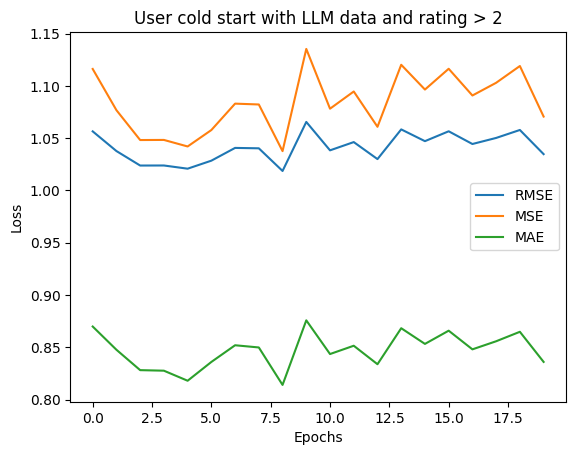

In [38]:
import matplotlib.pyplot as plt
plt.plot(np.arange(FLAGS.epochs), rmse_user_cold, label="RMSE")
plt.plot(np.arange(FLAGS.epochs), mse_user_cold, label="MSE")
plt.plot(np.arange(FLAGS.epochs), mae_user_cold, label="MAE")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("User cold start with LLM data and rating > 2")
plt.legend()
plt.savefig("cold_start_with_random_selection_llm_greater_than_2.png")